In [1]:
from init import *
from utility import *
from repro import readfile

autotime loaded.
black loaded.
black loaded.
time: 1.08 s


<IPython.core.display.Javascript object>

In [2]:
class Reprobus:
    def __init__(self, filename, nbcon=44, ncm=15, islev=np.arange(350, 801, 5)):
        p0, rascp = 1000.0, 2.0 / 7.0
        self.filename = filename
        self.date = pd.to_datetime(filename.split("_")[2], format="%Y%m%d%H")
        if self.date > pd.to_datetime("2019-07-31"):
            self.nlev = 137
        else:
            self.nlev = 60
        nlev = self.nlev
        pj1, uj1, vj1, alt, tj1, qj1, hc = readfile(filename, nlev, nbcon, ncm)
        # print(pj1)
        aa, bb = self.get_coeffs()
        pmb = np.zeros(tj1.shape)
        for i in np.arange(nlev):
            pmb[:, :, i] = aa[i] + bb[i] * pj1
        theta = tj1 * ((p0 / pmb) ** rascp)

        tr1 = {"Ozone": 4, "ClO": 10, "NO2": 6}
        tr2 = {
            "HNO3g": 42,
            "HNO3": 3,
            "N2O": 0,
            "POx": 10,
            "ClONO2": 13,
            "NOx": 20,
            "ClOx": 22,
            "BrOx": 23,
            "HCl": 12,
        }
        self.long_name = {
            "Ozone": "O$_3$",
            "ClO": "ClO",
            "HNO3g": "HNO$_3$ Gas",
            "HNO3": "HNO$_3$",
            "N2O": "N$_2$O",
            "NO2": "NO$_2$",
            "POx": "Passive Ox",
            "ClONO2": "ClONO$_2$",
            "NOx": "NO$_x$",
            "ClOx": "ClO$_x$",
            "BrOx": "BrO$_x$",
            "HCl": "HCl",
        }

        data = xr.Dataset()

        for k, v in tr1.items():
            data[k] = self.isentropic_tracers(hc[:, :, :, v], theta, islev, k)

        for k, v in tr2.items():
            data[k] = self.isentropic_tracers(qj1[:, :, :, v], theta, islev, k)

        self.data = data

    def get_coeffs(self, cdir="."):
        cfile = "%s/ecmwf_%s_levels.txt" % (cdir, self.nlev)
        # print(cfile)
        df = pd.read_csv(cfile, sep="\s+", skiprows=[1])
        df.columns = ["N", "a", "b", "c", "d"]
        aa = 0.01 * df["a"].rolling(1).mean()[1:].values
        bb = df["b"].rolling(1).mean()[1:].values
        # print(df["a"])
        # print(df["b"])
        return aa, bb

    def isentropic_tracers(self, tmp, theta, islev, tr):
        lats = xr.DataArray(
            np.arange(90, -91, -2), dims="Latitude", attrs={"long_name": "Latitude"}
        )
        lons = xr.DataArray(
            np.arange(0, 360, 2), dims="Longitude", attrs={"long_name": "Longitude"}
        )
        levs = np.arange(self.nlev)  # [::-1]

        coords = [lons, lats, levs]
        dims = ["Longitude", "Latitude", "Level"]
        tattrs = {"long_name": "Temperature", "units": "K"}

        theta = xr.DataArray(theta, coords=coords, dims=dims, attrs=tattrs)
        islev = xr.DataArray(islev, dims="Theta", attrs=tattrs)
        tmp = xr.DataArray(tmp / 1e-9, dims=dims, coords=coords)
        tmp = xrvinterp(tmp, theta, islev, "Level", "Theta")
        tmp.attrs = {"long_name": "%s [ppbv]" % self.long_name[tr]}
        return tmp

time: 5.87 ms


<IPython.core.display.Javascript object>

In [3]:
def get_basemap(ax=None, region="north"):
    if not ax:
        fig, ax = facets(1, 1, width=10, aspect=0.6)
        ax = ax[0]

    if region == "north":
        m = Basemap(projection="npstere", lon_0=0, boundinglat=30, round=True, ax=ax)
    else:
        m = Basemap(projection="spstere", lon_0=180, boundinglat=-30, round=True, ax=ax)
    m.drawcoastlines(linewidth=0.35)
    m.drawcountries(linewidth=0.35)
    m.drawmeridians(np.arange(0, 360, 60), labels=[0, 0, 0, 0])
    m.drawparallels(np.arange(20, 80, 20), labels=[1, 1, 0, 0])
    return m


def plot_data(molz, level=475, scale=1, region="north"):
    fig, ax = plt.subplots(1, 1, figsize=(9, 7))
    cax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
    m = get_basemap(ax=ax, region=region)
    data = molz.sel(Theta=level, method="nearest").T.values
    data, lon = addcyclic(data, molz["Longitude"])
    lat, lon = np.meshgrid(molz["Latitude"], lon)
    lon, lat = m(lon, lat)
    im = m.contourf(lon, lat, scale * data.T)
    cb = plt.colorbar(im, cax=cax, orientation="vertical")
    # cb.set_label(label="%s" % (molz.attrs["long_name"]), size=18)
    return fig, ax, cb

time: 2.62 ms


<IPython.core.display.Javascript object>

In [4]:
odir = "/media/pankaj/Data/reprobus/netcdf/"
files = sorted(glob.glob("/media/pankaj/Data/arc2020/*"))
files

['/media/pankaj/Data/arc2020/MODEL_history_2019120812_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019120812_001435.part',
 '/media/pankaj/Data/arc2020/MODEL_history_2019120912_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121012_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121012_001435.part',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121112_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121112_001435.part',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121212_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121212_001435.part',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121312_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121312_001435.part']

time: 3.79 ms


<IPython.core.display.Javascript object>

In [5]:
for filename in files[2:3]:
    print(filename)
    bus = Reprobus(filename)
    ncfile = f"%s%s.nc" % (odir, bus.date.isoformat().split("T")[0])
    print(f"Saving %s" % ncfile)
    bus.data[["Ozone", "POx"]].to_netcdf(ncfile)

/media/pankaj/Data/arc2020/MODEL_history_2019120912_001435
Saving /media/pankaj/Data/reprobus/netcdf/2019-12-09.nc
time: 1min 56s


<IPython.core.display.Javascript object>

In [6]:
# cfile = "./ecmwf_%s_levels.txt" % (137)
# print(cfile)
# df = pd.read_csv(cfile, sep="\s+", skiprows=[1])
# df.columns = ["N", "a", "b", "c", "d"]
# df

time: 311 µs


<IPython.core.display.Javascript object>

In [7]:
bus.data

<xarray.Dataset>
Dimensions:    (Latitude: 91, Longitude: 180, Theta: 91)
Coordinates:
  * Longitude  (Longitude) int64 0 2 4 6 8 10 12 ... 346 348 350 352 354 356 358
  * Latitude   (Latitude) int64 90 88 86 84 82 80 78 ... -80 -82 -84 -86 -88 -90
  * Theta      (Theta) int64 350 355 360 365 370 375 ... 775 780 785 790 795 800
Data variables:
    Ozone      (Longitude, Latitude, Theta) float64 363.6 510.5 ... 4.519e+03
    ClO        (Longitude, Latitude, Theta) float64 6.307e-21 ... 0.1128
    NO2        (Longitude, Latitude, Theta) float64 0.01068 0.01748 ... 5.497
    HNO3g      (Longitude, Latitude, Theta) float64 0.5484 1.233 ... 5.105 4.978
    HNO3       (Longitude, Latitude, Theta) float64 0.5983 1.338 ... 17.08 17.16
    N2O        (Longitude, Latitude, Theta) float64 314.3 305.2 ... 100.7 99.06
    POx        (Longitude, Latitude, Theta) float64 363.9 510.9 ... 4.888e+03
    ClONO2     (Longitude, Latitude, Theta) float64 0.006735 0.02228 ... 0.5319
    NOx        (Longitude, Latitude, Theta) float64 0.01107 0.01803 ... 11.49
    ClOx       (Longitude, Latitude, Theta) float64 6.307e-21 ... 0.1131
    BrOx       (Longitude, Latitude, Theta) float64 9.28e-20 1e-21 ... 0.01469
    HCl        (Longitude, Latitude, Theta) float64 0.1233 0.2387 ... 2.153

time: 49.3 ms


<IPython.core.display.Javascript object>

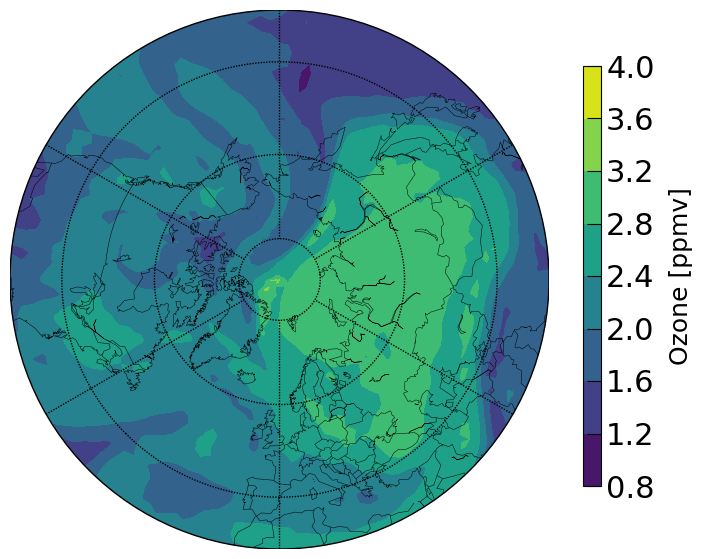

time: 581 ms


<IPython.core.display.Javascript object>

In [8]:
fig, ax, cb = plot_data(bus.data["Ozone"], level=475, scale=0.001, region="north")
cb.set_label(label="%s" % ("Ozone [ppmv]"), size=18)
# plt.savefig("/home/pankaj/Desktop/repro_ozone_435K.png", bbox_inches="tight")
plt.show()